In [1]:
import numpy as np
!pip install gymnasium
import gymnasium as gym
!pip install ale_py
import ale_py
import sys
import pylab
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from gymnasium import wrappers
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.2 MB/s eta 0:00:0000:0100:01


In [2]:
class DQN:
    def __init__(self, state_size, action_size, load_model=False):
        self.state_size = state_size
        self.action_size = action_size

        if load_model: # loading the model will disable training
            self.discount = 0.99
            self.learning_rate = 0.00001
            self.epsilon = 0.2 # exploring at 1 and exploiting at 0
            self.epsilon_decay = 0.99999
            self.epsilon_min = 0.2
        else:
            self.discount = 0.99
            self.learning_rate = 0.005
            self.epsilon = 1.0
            self.epsilon_decay = 0.9999
            self.epsilon_min = 0.1

        self.batch_size = 64
        self.train_start = 1000

        self.memory = deque(maxlen=2000)
        self.model = self.build_model()

        if load_model:
            self.model.load_weights('./results/pacman.h5')

    def build_model(self):
        model = Sequential()
        #model.add(Input(shape=(self.state_size,)))
        model.add(Input(shape=(84, 84, 1)))

        #model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        #model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        """model.add(Conv2D(32, (8, 8), strides=(4,4), activation='relu', kernel_initializer='he_uniform'))
        model.add(Conv2D(64, (4, 4), strides=(2,2), activation='relu', kernel_initializer='he_uniform'))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))

        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))"""

        """model.add(Conv2D(filters = 32,kernel_size = (8,8),strides = 4,data_format="channels_last", activation = 'relu',kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Conv2D(filters = 64,kernel_size = (4,4),strides = 2,data_format="channels_last", activation = 'relu',kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Conv2D(filters = 64,kernel_size = (3,3),strides = 1,data_format="channels_last", activation = 'relu',kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Flatten())
        model.add(Dense(512,activation = 'relu', kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Dense(len(self.action_size), activation = 'linear'))"""

        model.add(Conv2D(32, (8, 8), strides=4, activation='relu', kernel_initializer='he_uniform', ))
        model.add(Conv2D(64, (4, 4), strides=2, activation='relu', kernel_initializer='he_uniform', ))
        model.add(Conv2D(64, (3, 3), strides=1, activation='relu', kernel_initializer='he_uniform', ))
        model.add(Flatten())
        model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))

        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        model.summary()
        return model

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            with tf.device(device):
                act_values = self.model.predict(state, verbose=0) # get the Q-values for the state
            return np.argmax(act_values[0]) # return the action with the highest Q-value

    def append_memory(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        # if self.epsilon > self.epsilon_min:
        #     self.epsilon *= self.epsilon_decay

    def experience_replay(self): # experience replay
        # if len(self.memory) < self.train_start:
        #     return
        if len(self.memory) < self.batch_size:
            return

        #batch_size = min(len(self.memory), self.batch_size)
        #batch_size = self.batch_size
        minibatch = random.sample(self.memory, self.batch_size)

        #state = np.zeros((batch_size, self.state_size))
        #next_state = np.zeros((batch_size, self.state_size))
        state = np.zeros((self.batch_size, 84, 84, 1))
        next_state = np.zeros((self.batch_size, 84, 84, 1))

        action, reward, done = [], [], []

        for i in range(self.batch_size):
            state[i] = minibatch[i][0].reshape((84, 84, 1))
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3].reshape((84, 84, 1))
            done.append(minibatch[i][4])

        with tf.device(device):
            target = self.model.predict(state, verbose=0)
            target_next = self.model.predict(next_state, verbose=0)

        for i in range(self.batch_size):
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.discount * np.amax(target_next[i])
        with tf.device(device):
            self.model.fit(state, target, batch_size=self.batch_size, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
n_episodes = 101
environment = 'ALE/Pacman-v5'
path_training = './DQN/results/'
path_training = '/kaggle/working/'

"""from google.colab import drive
drive.mount('/content/drive')
path_training = '/content/drive/MyDrive/'"""

gym.register_envs(ale_py)
device = '/GPU:0' if tf.config.experimental.list_physical_devices('GPU') else '/CPU:0'

In [7]:
class Pacman:
    def __init__(self, mode, view):
        self.env = gym.make(environment, frameskip=1, render_mode=view) # rgb_array or human
        self.env.reset()
        size_state = self.env.observation_space.shape[0]
        size_action = self.env.action_space.n

        # network construction
        if mode.lower() == 'test':
            load_model = True
        else:
            load_model = False

        #self.agent = DQN(size_state, size_action, load_model)
        self.agent = DQN((84, 84, 1), size_action, load_model)

    def train(self, path, statistics, mode):
        if path:
            train_path = path
        else:
            train_path = path_training

        if statistics:
            print('Scores will be plotted')
        else:
            print('Scores will not be plotted')

        env = self.env
        env = wrappers.AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, screen_size=84)

        agent = self.agent

        size_state = self.env.observation_space.shape[0]
        scores, episodes = [], []

        scaler = tf.keras.layers.Rescaling(1./255)

        for e in tqdm(range(n_episodes)):
            done = False
            score = 0
            state, _ = env.reset()
            #state = np.reshape(state, [1, size_state])
            state = np.expand_dims(state, axis=-1) # 84x84x1 now
            state = np.moveaxis(state, 2, 0) / 255.0
            state = np.reshape(state, (1, 84, 84, 1))

            lives = 4
            while not done:
                dead = False
                while not dead:
                    action = agent.get_action(state)
                    next_state, reward, done, _, info = env.step(action)
                    #next_state = np.reshape(next_state, [1, size_state])
                    next_state = np.expand_dims(next_state, axis=-1)
                    next_state = np.moveaxis(next_state, 2, 0) / 255.0
                    next_state = np.reshape(next_state, (1, 84, 84, 1))

                    real_reward = reward
                    reward = reward + 0.05 if not dead else -10 # penalize deaths, encourage surviving

                    agent.append_memory(state, action, reward, next_state, done)
                    agent.experience_replay()


                    state = next_state
                    score += real_reward
                    dead = info['lives'] < lives
                    lives = info['lives']
                    #reward = reward if not dead else -10 # penalize deaths

                if done:
                    scores.append(score)
                    episodes.append(e)
                    #agent.update_target_model()

                    if statistics:
                        pylab.plot(episodes, scores, 'b')
                        pylab.savefig(train_path + 'pacman.png')
                    print('episode: {}/{}, score: {}, epsilon: {:.2}'.format(e, episodes, score, agent.epsilon))

            if e%50 == 0 and mode.lower() == 'train': # save the model every 50 episodes
                agent.model.save_weights(train_path + 'pacman.weights.h5')
                print('Model saved')

In [8]:
# run the code
pacman = Pacman('train', 'rgb_array')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 20, 20, 32)          │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 9, 9, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,680,549 (6.41 MB)

 Trainable params: 1,680,549 (6.41 MB)

 Non-trainable params: 0 (0.00 B)

Scores will be plotted


  1%|          | 1/101 [01:06<1:51:18, 66.78s/it]

episode: 0/[0], score: 13.0, epsilon: 0.97
Model saved


  2%|▏         | 2/101 [02:51<2:27:13, 89.23s/it]

episode: 1/[0, 1], score: 13.0, epsilon: 0.91


  3%|▎         | 3/101 [04:03<2:12:32, 81.15s/it]

episode: 2/[0, 1, 2], score: 18.0, epsilon: 0.88


  4%|▍         | 4/101 [05:06<1:59:59, 74.22s/it]

episode: 3/[0, 1, 2, 3], score: 10.0, epsilon: 0.85


  5%|▍         | 5/101 [06:38<2:08:48, 80.50s/it]

episode: 4/[0, 1, 2, 3, 4], score: 20.0, epsilon: 0.81


  6%|▌         | 6/101 [08:37<2:28:01, 93.49s/it]

episode: 5/[0, 1, 2, 3, 4, 5], score: 26.0, epsilon: 0.76


  7%|▋         | 7/101 [10:27<2:35:05, 99.00s/it]

episode: 6/[0, 1, 2, 3, 4, 5, 6], score: 37.0, epsilon: 0.71


  8%|▊         | 8/101 [13:00<2:59:51, 116.04s/it]

episode: 7/[0, 1, 2, 3, 4, 5, 6, 7], score: 53.0, epsilon: 0.66


  9%|▉         | 9/101 [14:29<2:45:21, 107.84s/it]

episode: 8/[0, 1, 2, 3, 4, 5, 6, 7, 8], score: 17.0, epsilon: 0.63


 10%|▉         | 10/101 [15:33<2:22:37, 94.04s/it]

episode: 9/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], score: 5.0, epsilon: 0.61


 11%|█         | 11/101 [16:52<2:14:17, 89.53s/it]

episode: 10/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], score: 19.0, epsilon: 0.59


 12%|█▏        | 12/101 [18:10<2:07:27, 85.93s/it]

episode: 11/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], score: 20.0, epsilon: 0.57


 13%|█▎        | 13/101 [19:25<2:01:28, 82.82s/it]

episode: 12/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], score: 16.0, epsilon: 0.55


 14%|█▍        | 14/101 [20:48<2:00:07, 82.84s/it]

episode: 13/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], score: 12.0, epsilon: 0.52


 15%|█▍        | 15/101 [22:14<2:00:00, 83.73s/it]

episode: 14/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], score: 20.0, epsilon: 0.5


 16%|█▌        | 16/101 [23:42<2:00:42, 85.21s/it]

episode: 15/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], score: 13.0, epsilon: 0.48


 17%|█▋        | 17/101 [25:19<2:04:03, 88.61s/it]

episode: 16/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], score: 19.0, epsilon: 0.46


 18%|█▊        | 18/101 [26:54<2:05:20, 90.60s/it]

episode: 17/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], score: 20.0, epsilon: 0.44


 19%|█▉        | 19/101 [28:29<2:05:22, 91.74s/it]

episode: 18/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], score: 11.0, epsilon: 0.42


 20%|█▉        | 20/101 [29:40<1:55:32, 85.58s/it]

episode: 19/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], score: 11.0, epsilon: 0.41


 21%|██        | 21/101 [31:55<2:13:57, 100.47s/it]

episode: 20/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], score: 26.0, epsilon: 0.38


 22%|██▏       | 22/101 [33:05<2:00:17, 91.36s/it] 

episode: 21/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], score: 11.0, epsilon: 0.37


 23%|██▎       | 23/101 [34:29<1:56:01, 89.24s/it]

episode: 22/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], score: 13.0, epsilon: 0.36


 24%|██▍       | 24/101 [35:59<1:54:29, 89.22s/it]

episode: 23/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], score: 21.0, epsilon: 0.34


 25%|██▍       | 25/101 [38:42<2:21:16, 111.54s/it]

episode: 24/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], score: 52.0, epsilon: 0.32


 26%|██▌       | 26/101 [40:00<2:06:47, 101.43s/it]

episode: 25/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], score: 18.0, epsilon: 0.31


 27%|██▋       | 27/101 [41:27<1:59:35, 96.97s/it] 

episode: 26/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26], score: 10.0, epsilon: 0.29


 28%|██▊       | 28/101 [42:49<1:52:39, 92.59s/it]

episode: 27/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], score: 14.0, epsilon: 0.28


 29%|██▊       | 29/101 [44:04<1:44:56, 87.45s/it]

episode: 28/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], score: 9.0, epsilon: 0.27


 30%|██▉       | 30/101 [46:22<2:01:06, 102.34s/it]

episode: 29/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], score: 35.0, epsilon: 0.26


 31%|███       | 31/101 [48:08<2:00:39, 103.42s/it]

episode: 30/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], score: 20.0, epsilon: 0.24


 32%|███▏      | 32/101 [49:34<1:52:55, 98.20s/it] 

episode: 31/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], score: 14.0, epsilon: 0.24


 33%|███▎      | 33/101 [51:23<1:55:06, 101.57s/it]

episode: 32/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32], score: 29.0, epsilon: 0.22


 34%|███▎      | 34/101 [53:00<1:51:57, 100.26s/it]

episode: 33/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], score: 27.0, epsilon: 0.21


 35%|███▍      | 35/101 [55:20<2:03:25, 112.20s/it]

episode: 34/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34], score: 36.0, epsilon: 0.2


 36%|███▌      | 36/101 [56:45<1:52:41, 104.02s/it]

episode: 35/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], score: 12.0, epsilon: 0.19


 37%|███▋      | 37/101 [58:33<1:52:08, 105.14s/it]

episode: 36/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36], score: 26.0, epsilon: 0.19


 38%|███▊      | 38/101 [1:00:02<1:45:25, 100.40s/it]

episode: 37/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37], score: 17.0, epsilon: 0.18


 39%|███▊      | 39/101 [1:03:27<2:16:07, 131.73s/it]

episode: 38/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38], score: 33.0, epsilon: 0.16


 40%|███▉      | 40/101 [1:05:09<2:04:59, 122.94s/it]

episode: 39/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], score: 18.0, epsilon: 0.16


 41%|████      | 41/101 [1:06:48<1:55:30, 115.51s/it]

episode: 40/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40], score: 16.0, epsilon: 0.15


 42%|████▏     | 42/101 [1:08:14<1:45:01, 106.80s/it]

episode: 41/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41], score: 15.0, epsilon: 0.14


 43%|████▎     | 43/101 [1:10:18<1:48:12, 111.94s/it]

episode: 42/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42], score: 19.0, epsilon: 0.14


 44%|████▎     | 44/101 [1:12:03<1:44:26, 109.93s/it]

episode: 43/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43], score: 24.0, epsilon: 0.13


 45%|████▍     | 45/101 [1:13:25<1:34:38, 101.41s/it]

episode: 44/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], score: 8.0, epsilon: 0.12


 46%|████▌     | 46/101 [1:15:13<1:34:42, 103.32s/it]

episode: 45/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], score: 27.0, epsilon: 0.12


 47%|████▋     | 47/101 [1:17:36<1:43:48, 115.35s/it]

episode: 46/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], score: 37.0, epsilon: 0.11


 48%|████▊     | 48/101 [1:18:55<1:32:10, 104.35s/it]

episode: 47/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], score: 10.0, epsilon: 0.11


 49%|████▊     | 49/101 [1:21:06<1:37:24, 112.39s/it]

episode: 48/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], score: 38.0, epsilon: 0.1


 50%|████▉     | 50/101 [1:22:30<1:28:17, 103.87s/it]

episode: 49/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], score: 12.0, epsilon: 0.1


 50%|█████     | 51/101 [1:23:56<1:22:06, 98.53s/it] 

episode: 50/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], score: 19.0, epsilon: 0.1
Model saved


 51%|█████▏    | 52/101 [1:25:26<1:18:22, 95.97s/it]

episode: 51/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51], score: 23.0, epsilon: 0.1


 52%|█████▏    | 53/101 [1:26:50<1:13:55, 92.40s/it]

episode: 52/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52], score: 12.0, epsilon: 0.1


 53%|█████▎    | 54/101 [1:28:11<1:09:44, 89.04s/it]

episode: 53/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53], score: 17.0, epsilon: 0.1


 54%|█████▍    | 55/101 [1:29:40<1:08:11, 88.95s/it]

episode: 54/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54], score: 13.0, epsilon: 0.1


 55%|█████▌    | 56/101 [1:31:21<1:09:27, 92.60s/it]

episode: 55/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55], score: 22.0, epsilon: 0.1


 56%|█████▋    | 57/101 [1:32:47<1:06:25, 90.59s/it]

episode: 56/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56], score: 20.0, epsilon: 0.1


 57%|█████▋    | 58/101 [1:34:20<1:05:29, 91.38s/it]

episode: 57/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57], score: 14.0, epsilon: 0.1


 58%|█████▊    | 59/101 [1:35:51<1:03:50, 91.21s/it]

episode: 58/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58], score: 10.0, epsilon: 0.1


 59%|█████▉    | 60/101 [1:37:18<1:01:29, 89.98s/it]

episode: 59/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], score: 6.0, epsilon: 0.1


 60%|██████    | 61/101 [1:38:45<59:20, 89.00s/it]  

episode: 60/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60], score: 10.0, epsilon: 0.1


 61%|██████▏   | 62/101 [1:40:14<57:49, 88.95s/it]

episode: 61/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61], score: 6.0, epsilon: 0.1


 62%|██████▏   | 63/101 [1:41:35<54:52, 86.65s/it]

episode: 62/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62], score: 9.0, epsilon: 0.1


 63%|██████▎   | 64/101 [1:43:14<55:48, 90.49s/it]

episode: 63/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], score: 11.0, epsilon: 0.1


 64%|██████▍   | 65/101 [1:44:45<54:14, 90.41s/it]

episode: 64/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64], score: 16.0, epsilon: 0.1


 65%|██████▌   | 66/101 [1:46:05<51:03, 87.53s/it]

episode: 65/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65], score: 4.0, epsilon: 0.1


 66%|██████▋   | 67/101 [1:47:31<49:20, 87.08s/it]

episode: 66/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66], score: 6.0, epsilon: 0.1


 67%|██████▋   | 68/101 [1:48:54<47:12, 85.83s/it]

episode: 67/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67], score: 5.0, epsilon: 0.1


 68%|██████▊   | 69/101 [1:50:41<49:09, 92.16s/it]

episode: 68/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68], score: 20.0, epsilon: 0.1


 69%|██████▉   | 70/101 [1:52:07<46:33, 90.11s/it]

episode: 69/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69], score: 15.0, epsilon: 0.1


 70%|███████   | 71/101 [1:53:22<42:51, 85.72s/it]

episode: 70/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70], score: 5.0, epsilon: 0.1


 71%|███████▏  | 72/101 [1:54:46<41:10, 85.18s/it]

episode: 71/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71], score: 5.0, epsilon: 0.1


 72%|███████▏  | 73/101 [1:56:14<40:11, 86.13s/it]

episode: 72/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72], score: 14.0, epsilon: 0.1


 73%|███████▎  | 74/101 [1:57:43<39:09, 87.01s/it]

episode: 73/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73], score: 5.0, epsilon: 0.1


 74%|███████▍  | 75/101 [1:59:13<37:58, 87.65s/it]

episode: 74/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74], score: 11.0, epsilon: 0.1


 75%|███████▌  | 76/101 [2:00:35<35:53, 86.16s/it]

episode: 75/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75], score: 5.0, epsilon: 0.1


 76%|███████▌  | 77/101 [2:02:14<35:55, 89.82s/it]

episode: 76/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76], score: 15.0, epsilon: 0.1


 77%|███████▋  | 78/101 [2:03:55<35:48, 93.42s/it]

episode: 77/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77], score: 25.0, epsilon: 0.1


 78%|███████▊  | 79/101 [2:05:17<32:57, 89.89s/it]

episode: 78/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78], score: 5.0, epsilon: 0.1


 79%|███████▉  | 80/101 [2:06:36<30:21, 86.73s/it]

episode: 79/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79], score: 7.0, epsilon: 0.1


 80%|████████  | 81/101 [2:08:03<28:51, 86.55s/it]

episode: 80/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80], score: 10.0, epsilon: 0.1


 81%|████████  | 82/101 [2:09:24<26:53, 84.90s/it]

episode: 81/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81], score: 6.0, epsilon: 0.1


 82%|████████▏ | 83/101 [2:10:46<25:16, 84.27s/it]

episode: 82/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82], score: 5.0, epsilon: 0.1


 83%|████████▎ | 84/101 [2:12:08<23:38, 83.43s/it]

episode: 83/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83], score: 5.0, epsilon: 0.1


 84%|████████▍ | 85/101 [2:13:37<22:44, 85.25s/it]

episode: 84/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84], score: 9.0, epsilon: 0.1


 85%|████████▌ | 86/101 [2:15:01<21:12, 84.86s/it]

episode: 85/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85], score: 16.0, epsilon: 0.1


 86%|████████▌ | 87/101 [2:16:31<20:07, 86.22s/it]

episode: 86/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86], score: 5.0, epsilon: 0.1


 87%|████████▋ | 88/101 [2:18:17<19:59, 92.30s/it]

episode: 87/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87], score: 19.0, epsilon: 0.1


 88%|████████▊ | 89/101 [2:19:35<17:34, 87.90s/it]

episode: 88/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88], score: 4.0, epsilon: 0.1


 89%|████████▉ | 90/101 [2:21:02<16:03, 87.61s/it]

episode: 89/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89], score: 4.0, epsilon: 0.1


 90%|█████████ | 91/101 [2:22:44<15:19, 91.92s/it]

episode: 90/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90], score: 22.0, epsilon: 0.1


 91%|█████████ | 92/101 [2:24:18<13:54, 92.70s/it]

episode: 91/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91], score: 14.0, epsilon: 0.1


 92%|█████████▏| 93/101 [2:25:45<12:06, 90.87s/it]

episode: 92/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92], score: 14.0, epsilon: 0.1


 93%|█████████▎| 94/101 [2:27:03<10:09, 87.05s/it]

episode: 93/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93], score: 8.0, epsilon: 0.1


 94%|█████████▍| 95/101 [2:28:52<09:21, 93.52s/it]

episode: 94/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94], score: 12.0, epsilon: 0.1


 95%|█████████▌| 96/101 [2:30:06<07:19, 87.93s/it]

episode: 95/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], score: 9.0, epsilon: 0.1


 96%|█████████▌| 97/101 [2:31:40<05:58, 89.69s/it]

episode: 96/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96], score: 24.0, epsilon: 0.1


 97%|█████████▋| 98/101 [2:33:34<04:50, 96.82s/it]

episode: 97/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97], score: 17.0, epsilon: 0.1


 98%|█████████▊| 99/101 [2:35:32<03:26, 103.39s/it]

episode: 98/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98], score: 29.0, epsilon: 0.1


 99%|█████████▉| 100/101 [2:37:05<01:40, 100.11s/it]

episode: 99/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], score: 4.0, epsilon: 0.1


100%|██████████| 101/101 [2:38:30<00:00, 94.16s/it] 

episode: 100/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100], score: 6.0, epsilon: 0.1
Model saved


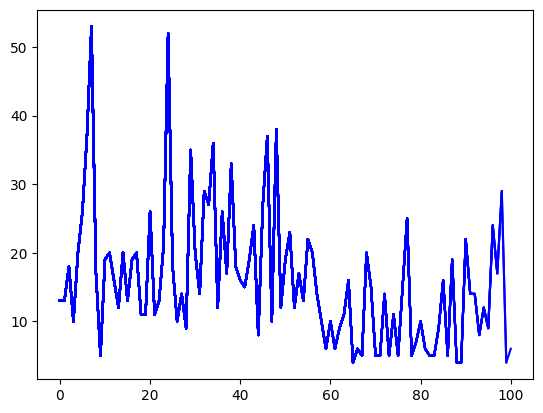

In [9]:
pacman.train(path=path_training, statistics=True, mode='train')